<a href="https://colab.research.google.com/github/SauloHenriqueAguiar/DeepLearningCNN/blob/main/Cifar10PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


Treinando um Classificador
=====================

usaremos o conjunto de dados CIFAR10. Tem as classes: ‘avião’, ‘automóvel’, ‘pássaro’, ‘gato’, ‘veado’, ‘cão’, ‘sapo’, ‘cavalo’, ‘navio’, ‘caminhão’. As imagens no CIFAR-10 são de tamanho 3x32x32, ou seja, imagens coloridas de 3 canais com tamanho de 32x32 pixels.







In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

A saída dos conjuntos de dados torchvision são imagens PILImage de intervalo [0, 1]. Nós os transformamos em tensores de faixa normalizada [-1, 1].


Carregando os Dataset

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


mostra algumas das imagens de treinamento



 ship   cat  bird  frog


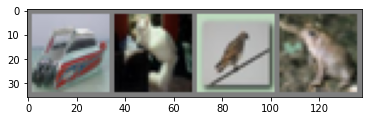

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

##2. Define a Rede Neural Convolucional

Copia a rede neural da seção Redes Neurais anterior e modifique-a para obter imagens de 3 canais (em vez de imagens de 1 canal como foi definido).



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

##3. Define a função de Perda e Otimizador

Vamos usar uma perda de entropia cruzada de classificação e SGD com momentum.



In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

##4. Treinamento da Rede

Nós simplesmente temos que fazer um loop em nosso iterador de dados e alimentar as entradas para o
rede e otimizar.



In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.199
[1,  4000] loss: 1.864
[1,  6000] loss: 1.684
[1,  8000] loss: 1.594
[1, 10000] loss: 1.523
[1, 12000] loss: 1.509
[2,  2000] loss: 1.418
[2,  4000] loss: 1.391
[2,  6000] loss: 1.344
[2,  8000] loss: 1.344
[2, 10000] loss: 1.330
[2, 12000] loss: 1.289
Finished Training


##5. Teste a rede nos dados de teste

precisamos verificar se a rede aprendeu alguma coisa.
Vamos verificar isso prevendo o rótulo da classe que a rede neural
saídas e comparando-as com a verdade. Se a previsão for
correto, adicionamos a amostra à lista de previsões corretas.


GroundTruth:    cat  ship  ship plane


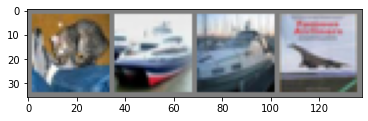

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

agora vamos ver o que a rede neural pensa que esses exemplos acima são:



In [11]:
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car  ship


Os resultados parecem muito bons.

Vejamos como a rede funciona em todo o conjunto de dados.



In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


Isso parece muuuito melhor do que o acaso, que tem 10% de precisão (escolher aleatoriamente uma classe entre 10 classes). Parece que a rede aprendeu alguma coisa.

Hmmm, quais são as classes que tiveram um bom desempenho e as classes que não tiveram um bom desempenho:


In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 51 %
Accuracy of   car : 72 %
Accuracy of  bird : 25 %
Accuracy of   cat : 34 %
Accuracy of  deer : 62 %
Accuracy of   dog : 28 %
Accuracy of  frog : 76 %
Accuracy of horse : 61 %
Accuracy of  ship : 64 %
Accuracy of truck : 58 %


Ok, então o que vem a seguir?

Como executamos essas redes neurais na GPU?

Treinamento em GPU
----------------
Assim como você transfere um Tensor para a GPU, você transfere o
rede para a GPU.

Vamos primeiro definir nosso dispositivo como o primeiro dispositivo cuda visível se tivermos
CUDA disponível:



In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Suponha que estamos em uma máquina CUDA, então isso deve imprimir um dispositivo CUDA:

print(device)

cuda:0


O resto desta seção assume que `dispositivo` é um dispositivo CUDA.

Então, esses métodos irão recursivamente percorrer todos os módulos e converter seus
parâmetros e buffers para tensores CUDA:

     net.to (dispositivo)

Lembre-se de que você também terá que enviar as entradas e alvos em cada etapa para a GPU:

     entradas, rótulos = inputs.to (dispositivo), labels.to (dispositivo)

Por que não noto uma aceleração MASSIVA em comparação com a CPU? Porque sua rede é realmente pequena.
